# Mock Approval dataset by CTAB-GAN
### ***Introduction***
CTAB-GAN is a conditional GAN based tabular data generator. CTAB-GAN advances beyond the prior state-of-the-art methods by modeling mixed variables and provides strong generation capability for imbalanced categorical variables, and continuous variables with complex distributions. To such ends, the core features of CTAB-GAN include as follows:
- (i)introduction of the classifier into conditional GAN;    
- (ii) effective data encoding for mixed variable;    
- (iii) a novel construction of conditional vectors.            

This dataset is aimed at the case of customers' default payments in Taiwan, which is used to get predictive accuracy of probability of default.                       
### ***Our work***   
We use CTAB-GAN to simulate Appraval data and visualize real and fake data. See code, comments, and diagrams for details.             
### ***Reference:***
[1] I. Yeh (2009). Default of Credit Card Clients [Dataset]. UCI Machine Learning Repository. Available: http://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients.           
[2] Z. Zhao, A. Kunar, R. Birke, and L. Y. Chen, “CTAB-GAN: Effective Table Data Synthesizing,” in Asian Conference on Machine Learning. PMLR, 2021, pp. 97–112.   

***Time ： 2024/11/26 17:25***  
***Author ： Chuang Liu***  
***Email ：LIUC0316@126.COM***  
***File ：Approval_Mocking.ipynb***  
***Notebook ：Jupyter***   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/CTAB-GAN-Plus/CTAB-GAN-Plus')

In [ ]:
import torch
print(torch.cuda.is_available())
!nvidia-smi

In [1]:
# !pip install dython
# Importing the model
from model.ctabgan import CTABGAN
# Importing the evaluation metrics 
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics
# Importing standard libraries
import numpy as np
import pandas as pd
import glob

In [2]:
# Specifying the replication number 
num_exp = 1 
# Specifying the name of the dataset used 
dataset = "Default" 
# Specifying the path of the dataset used 
real_path = "Real_Datasets/Default/Default.csv" 
# Specifying the root directory for storing generated data
fake_file_root = "Fake_Datasets" 

In [3]:
# Initializing the synthesizer object and specifying input parameters
# Notice: If you have continuous variable, you do not need to explicitly assign it. It will be treated like 
# that by default
synthesizer =  CTABGAN(raw_csv_path = real_path,
                 test_ratio = 0.20,  
                 categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default payment next month'], 
                 log_columns = [],
                 mixed_columns= {'BILL_AMT1':[0.0],'BILL_AMT2':[0.0],'BILL_AMT3':[0.0],'BILL_AMT4':[0.0],'BILL_AMT5':[0.0],'BILL_AMT6':[0.0], 'PAY_AMT1':[0.0],'PAY_AMT2':[0.0],'PAY_AMT3':[0.0],'PAY_AMT4':[0.0],'PAY_AMT5':[0.0],'PAY_AMT6':[0.0]}, 
                 integer_columns = ['LIMIT_BAL', 'AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6', 'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'],
                 problem_type= {"Classification": 'default payment next month'},
                 epochs = 150) 

# Fitting the synthesizer to the training dataset and generating synthetic data
synthesizer.fit()

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [2:37:03<00:00, 62.83s/it]

Finished training in 9467.53116774559  seconds.


In [4]:
for i in range(num_exp):
    syn = synthesizer.generate_samples()
    syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

In [5]:
# Collecting the paths to all corresponding generated datasets for evaluation 
fake_paths = glob.glob(fake_file_root+"/"+dataset+"/"+"*")

In [6]:
# Specifying the list of classifiers to conduct ML utility evaluation
classifiers_list = ["lr","dt","rf","mlp","svm"]

# Storing and presenting the results as a dataframe
result_mat = get_utility_metrics(real_path,fake_paths,"MinMax",classifiers_list, test_ratio = 0.20)
result_df  = pd.DataFrame(result_mat,columns=["Acc","AUC","F1_Score"])
result_df.index = classifiers_list
result_df

,Acc,AUC,F1_Score
lr,0.366667,0.032571,-0.000857
dt,7.166667,0.050423,0.056997
rf,1.500000,0.080240,0.111102
mlp,2.983333,0.117113,0.060007
svm,1.283333,0.058517,0.063096


In [7]:
# Specifying the categorical columns of the dataset used
adult_categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']

# Storing and presenting the results as a dataframe
stat_res_avg = []
for fake_path in fake_paths:
    stat_res = stat_sim(real_path,fake_path,adult_categorical)
    stat_res_avg.append(stat_res)

stat_columns = ["Average WD (Continuous Columns","Average JSD (Categorical Columns)","Correlation Distance"]
stat_results = pd.DataFrame(np.array(stat_res_avg).mean(axis=0).reshape(1,3),columns=stat_columns)
stat_results

,Average WD (Continuous Columns,Average JSD (Categorical Columns),Correlation Distance
0,0.018514,NaN,0.0


In [8]:
# Storing and presenting the results as a dataframe
priv_res_avg = []
for fake_path in fake_paths:
    priv_res = privacy_metrics(real_path,fake_path)
    priv_res_avg.append(priv_res)
    
privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
privacy_results = pd.DataFrame(np.array(priv_res_avg).mean(axis=0).reshape(1,6),columns=privacy_columns)
privacy_results

,DCR between Real and Fake (5th perc),DCR within Real(5th perc),DCR within Fake (5th perc),NNDR between Real and Fake (5th perc),NNDR within Real (5th perc),NNDR within Fake (5th perc)
0,0.826983,0.29328,0.359487,0.748704,0.503214,0.569207


In [9]:
# Storing generated data for future use if needed
# syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

In [10]:
# !pip install table_evaluator

In [11]:
from table_evaluator import TableEvaluator

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

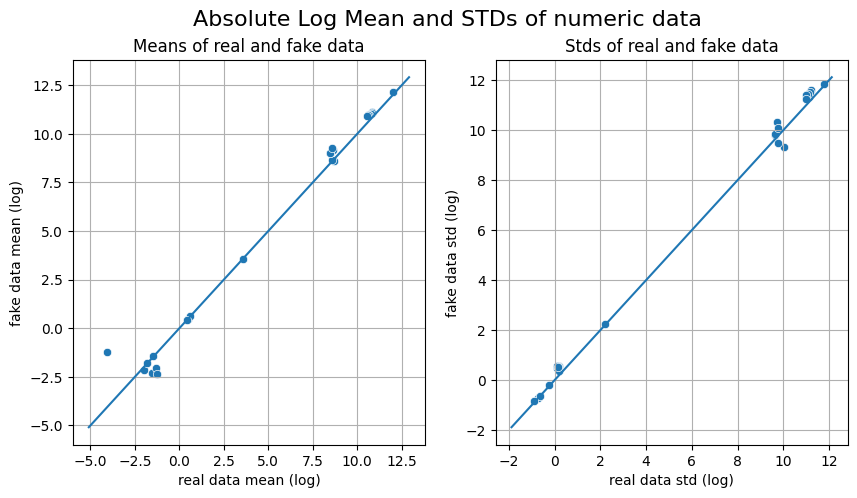

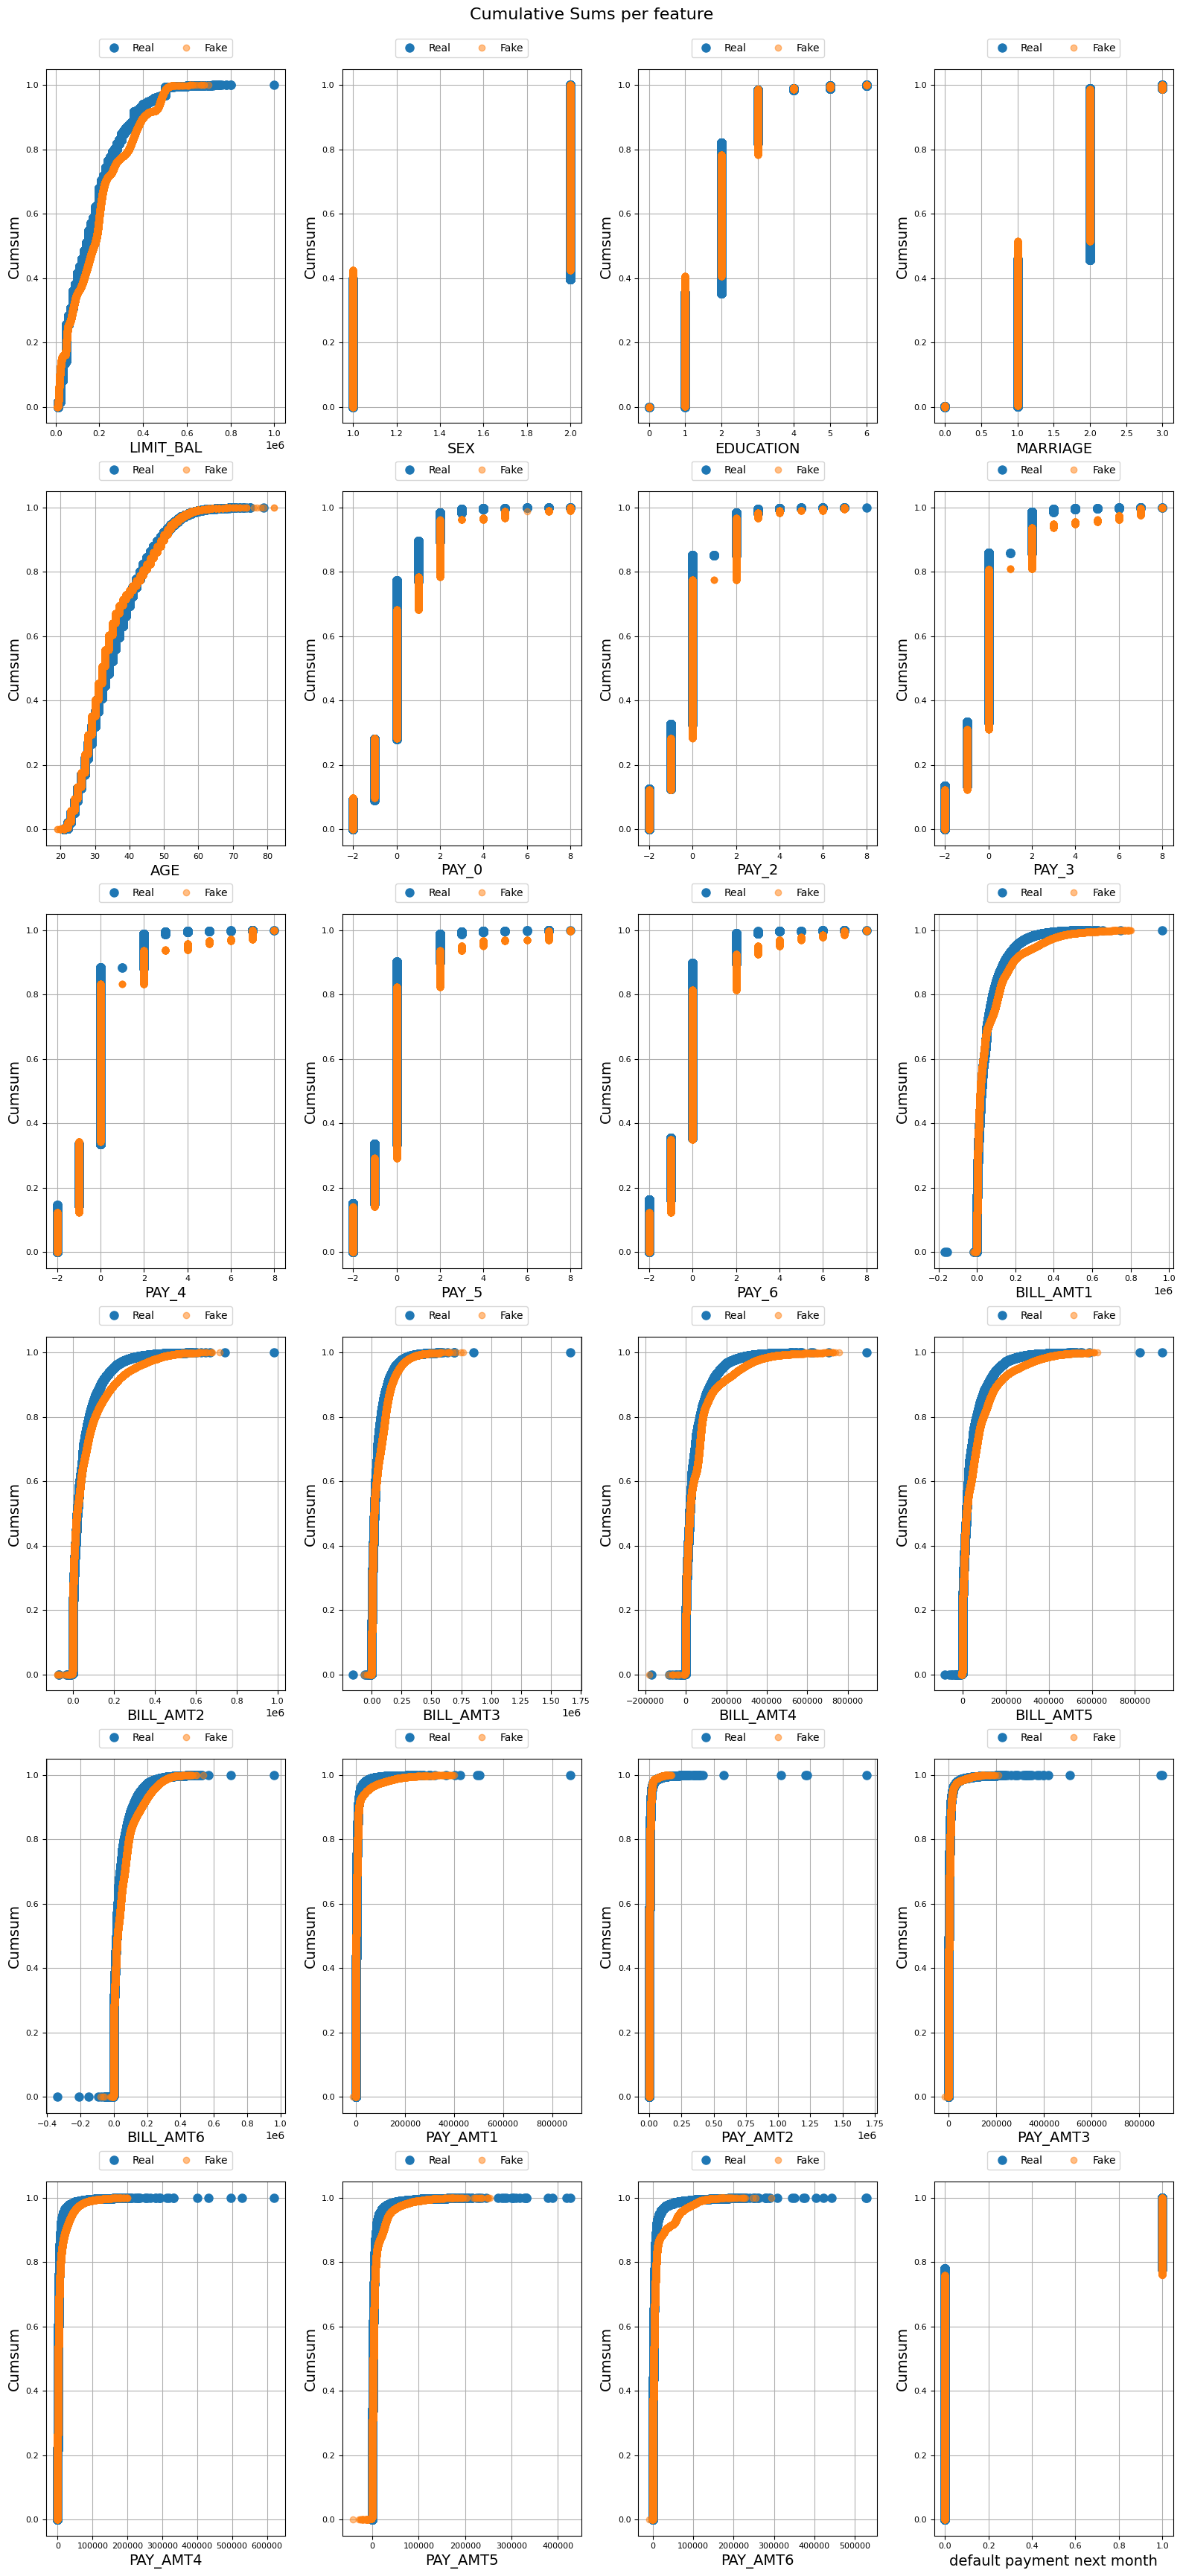

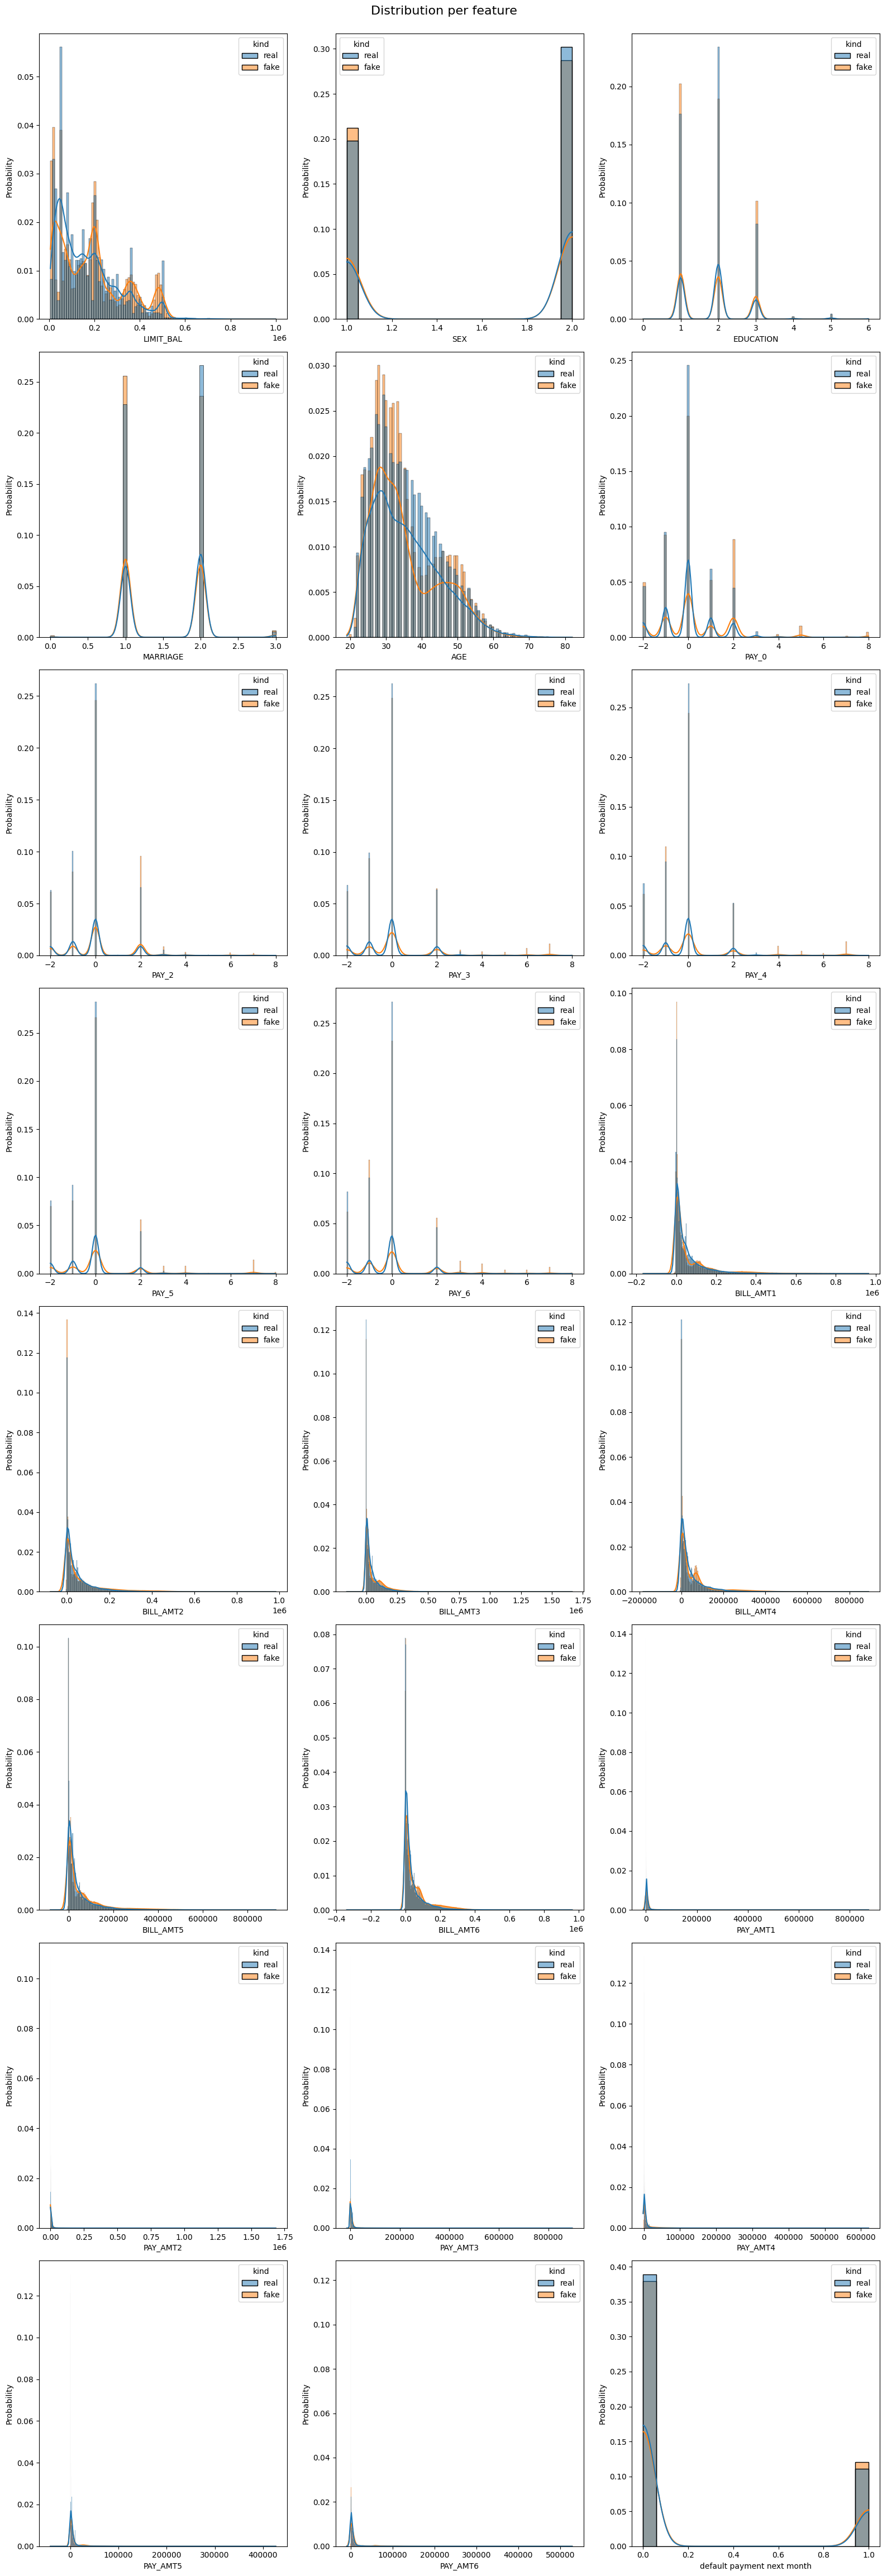

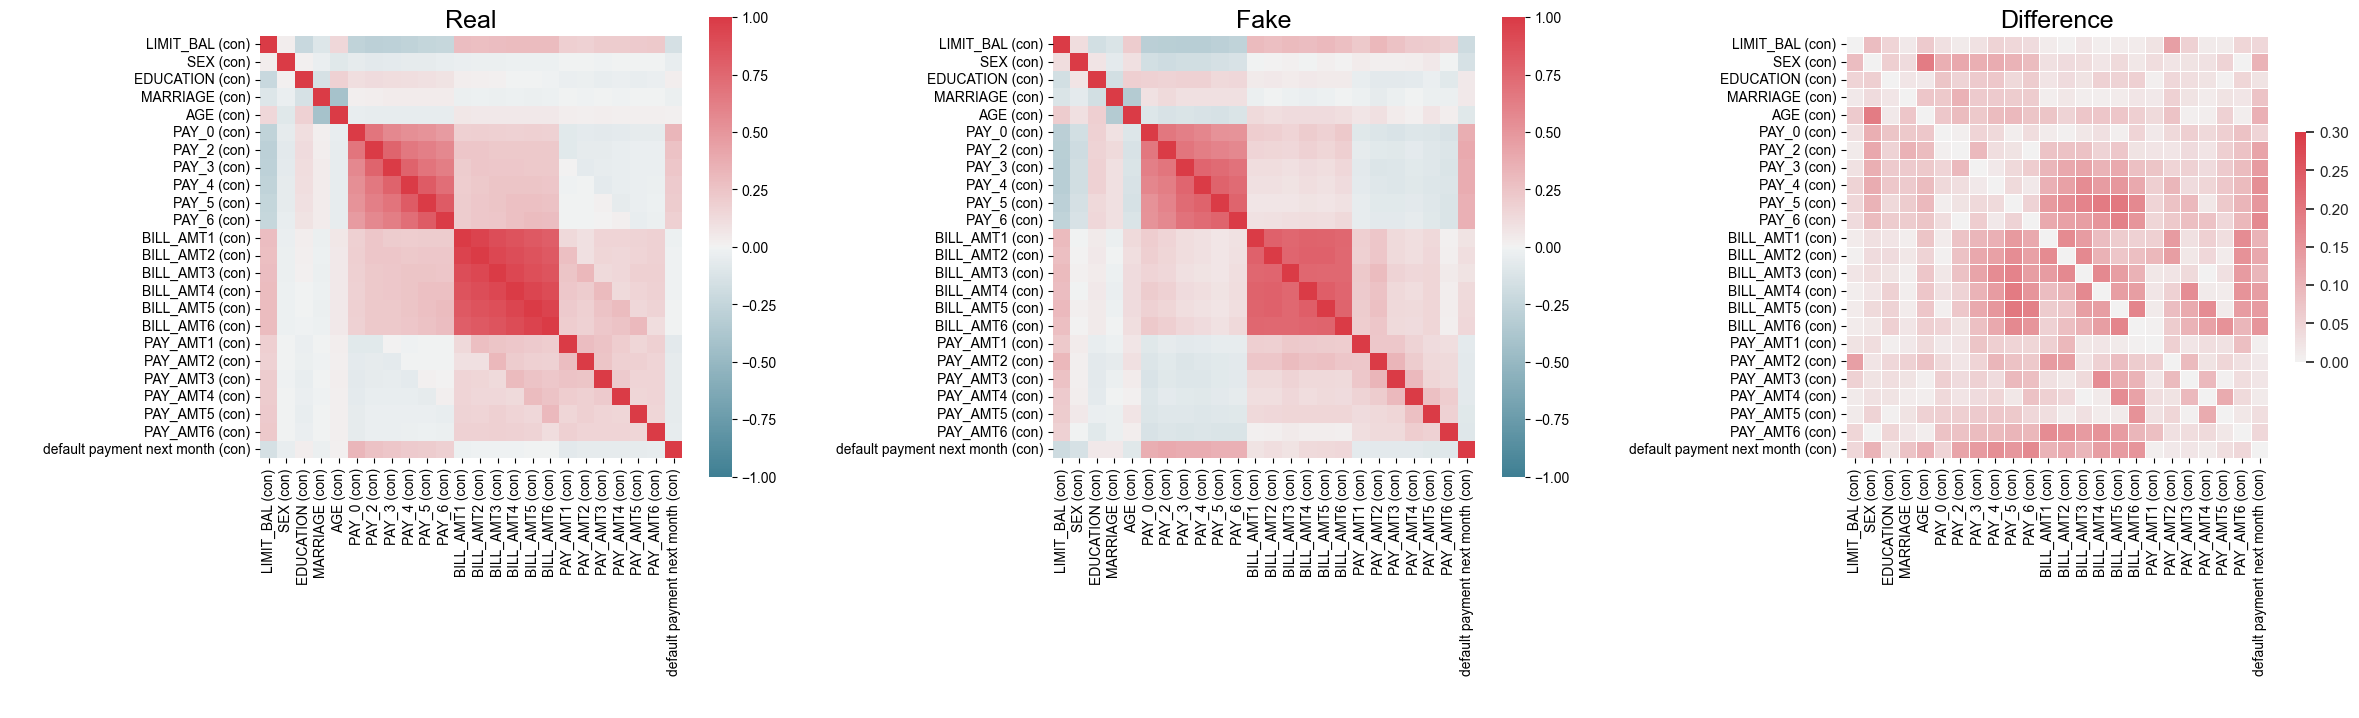

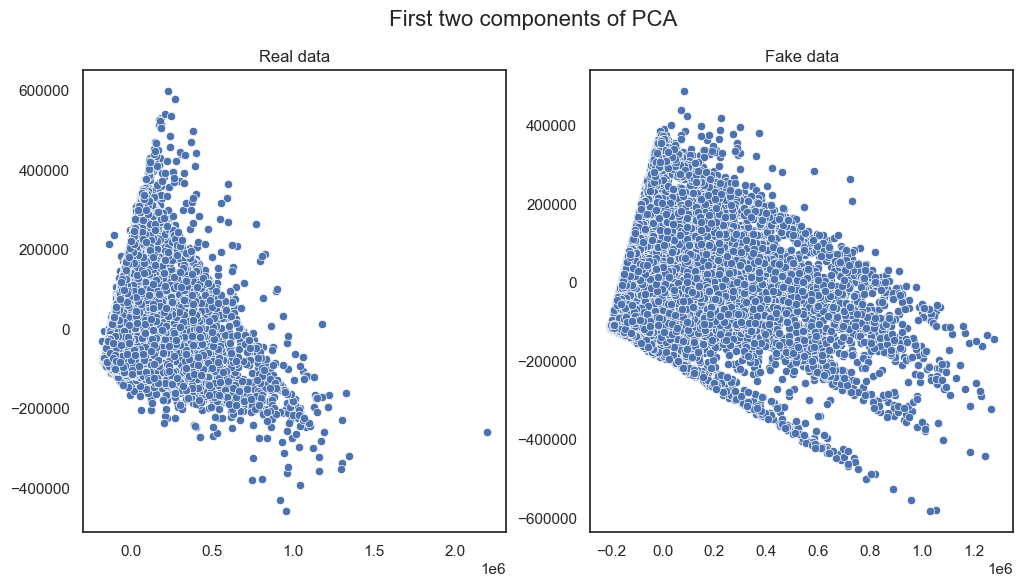

In [12]:
# !pip install scipy==1.11.4
Real_Dataset = pd.read_csv('Real_Datasets/Default/Default.csv')
Fake_Dataset = pd.read_csv('Fake_Datasets/Default/Default_fake_0.csv')

Real_Dataset.head()
Real_Dataset.info()
Fake_Dataset.head()
Fake_Dataset.info()

print(Real_Dataset.shape, Fake_Dataset.shape)
table_evaluator = TableEvaluator(Real_Dataset, Fake_Dataset)

table_evaluator.visual_evaluation()